<a href="https://colab.research.google.com/github/keamanansiber/Maryam/blob/master/notebooks/Prototipe_1_TopicModeling_KMeans_Wordcloud_14062022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install maryam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 272 kB 4.3 MB/s 
     |████████████████████████████████| 272 kB 56.3 MB/s 
     |████████████████████████████████| 271 kB 48.3 MB/s 
     |████████████████████████████████| 97 kB 6.1 MB/s 
     |████████████████████████████████| 125 kB 58.8 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
  Created wheel for maryam: filename=maryam-2.5.0.post3-py3-none-any.whl size=395895 sha256=4c2f0a0e9ef03e9cc3635b7c139bc4bbcde84f4da50d9e2a75a807ea736543d2
  Stored in directory: /root/.cache/pip/wheels/15/48/8f/fb3f7112ad7b199bcde760a46014524873d9f9a15ce5938e82
Successfully built maryam


In [2]:
# core/util/iris/topicmodeling.py

import re
import os
import json
from time import time
from html import unescape
import json

from collections import defaultdict, Counter, OrderedDict
import numpy as np
import pandas as pd
import scipy.sparse as sparse

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('stopwords')		
from nltk.corpus import stopwords
from sklearn.cluster import KMeans


class topicmodeling:
	
	def __init__(self, input_json):
		self.en_stopwords = set(stopwords.words('english'))
		with open(input_json) as json_file:
			self.data = json.load(json_file)
			print(self.data)
	

	# to remove the punctuation and the stop words so our algorithms use only the "useful" words.
	def process(self, sentence):
		terms = []
		for term in sentence:
			term = term.lower()
			if term not in self.en_stopwords and term.isalnum():
				terms.append(term)
		return terms

	
	def perform_kmeans(self):		

		# Prepare documents + cleaning
		docs = OrderedDict()
		
		for tmp in self.data['results']:
			docs[tmp['a']] = [ self.process(tmp['d'].split()) ]
		
		
		# construct indices.
		ix2doc = list(docs)
		doc2ix = {fid: i for i, fid in enumerate(ix2doc)}
		vocabulary = set()
		
		term_counts = defaultdict(Counter)
		document_counts = Counter()
		
		for fid, doc in docs.items():
			unique_terms = set()
			for sentence in doc:
				term_counts[fid].update(sentence)
				unique_terms.update(sentence)
			document_counts.update(unique_terms)
			vocabulary.update(unique_terms)
		
		ix2term = sorted(list(vocabulary))
		term2ix = OrderedDict()
		for i, term in enumerate(ix2term):
			term2ix[term] = i
		

		# construct a matrix for TF and IDF.
		term_count_mat = sparse.dok_matrix((len(doc2ix), len(term2ix)))
		
		for fid, i in doc2ix.items():
			for term, count in term_counts[fid].items():
				j = term2ix[term]
				term_count_mat[i, j] = count
		term_count_mat = term_count_mat.todense()

		doc_count_vec = np.array(
			[document_counts[term] for term in term2ix.keys()])


		tf = np.log(term_count_mat + 1)
		idf = len(doc2ix) / (1 + doc_count_vec)
		
		tfidf = np.multiply(tf, idf)
		
		
		# build our model.
		K = 6
		clusters = ['cluster#{}'.format(k) for k in range(K)]
		model = KMeans(n_clusters=K, random_state=314)
		
		
		clustered = model.fit_transform(tfidf)
	
		cluster_term = pd.DataFrame( model.cluster_centers_.T, index=ix2term, columns=clusters )
		cluster_term = np.round(cluster_term, decimals=4)
		
		
		# print results
		results = {}
		for z in range(K):
			results[clusters[z]] = cluster_term.sort_values(by=clusters[z], ascending=False)[:10]
			print(clusters[z])
			print(results[clusters[z]])
		

		# display word clouds		
		font = {'weight' : 'bold', 'size'   : 22}
		fig, axs = plt.subplots(K // 2, 2, figsize=(10, 8))
		
		k = 0
		for i in range(len(axs)):
			for j in range(len(axs[i])):
				wc = WordCloud(colormap='Greys', background_color='white', max_words=10)
				im = wc.generate_from_frequencies(cluster_term[clusters[k]])
				axs[i][j].imshow(im, interpolation='bilinear')
				axs[i][j].axis("off")
				axs[i][j].set_title(clusters[k], **font)
				k += 1
		    
		plt.tight_layout()
		plt.show()


		return results

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Use dataset from Mr. Khausik's work https://github.com/k4u5h1k/Doclustering/blob/main/mixed.json
jsonfile = "mixed.json"

In [4]:
tm = topicmodeling(jsonfile)

{'results': [{'t': 'Movie Coverage - YouTube', 'a': 'https://www.youtube.com/channel/UCwYzZs_hwA6NdaQp6Hjhe5w', 'c': 'www.youtube.com › channel', 'd': 'The best of films and movie trailers. Pick your Favorite Genre in our playlists.Do you want your trailer featured on this channel ? Please feel free to conta...'}, {'t': 'Marvel Studios Celebrates The Movies - YouTube', 'a': 'https://www.youtube.com/watch%3Fv%3DQdpxoFcdORI', 'c': 'www.youtube.com › watch', 'd': 'Duration:     3:11    Posted:     3 days ago               \xa0\xa0VIDEO'}, {'t': 'FRESH Movie Trailers - YouTube', 'a': 'https://www.youtube.com/c/FreshMovieTrailers', 'c': 'www.youtube.com › FreshMovieTrailers', 'd': "All NEW MOVIE TRAILERS are Here! Don't miss the latest movie trailers and weekly recaps.You want your trailer featured on the channel ? Fell free to reach\xa0..."}, {'t': 'Movie: The Movie - YouTube', 'a': 'https://www.youtube.com/watch%3Fv%3Dw3NwB9PLxss', 'c': 'www.youtube.com › watch', 'd': 'Duration:     8:33 

# Display topic modeling results & word cloud

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


cluster#0
            cluster#0  cluster#1  cluster#2  cluster#3  cluster#4  cluster#5
roads        108.7626     0.0000        0.0        0.0        0.0        0.0
locals        68.6216    -0.0000        0.0        0.0        0.0        0.0
melody        68.6216    -0.0000        0.0        0.0        0.0        0.0
japanese      68.6216    -0.0000        0.0        0.0        0.0        0.0
paths         68.6216    -0.0000        0.0        0.0        0.0        0.0
stretching    68.6216    -0.0000        0.0        0.0        0.0        0.0
175           68.6216    -0.0000        0.0        0.0        0.0        0.0
call          68.6216    -0.0000        0.0        0.0        0.0        0.0
250           45.7477     0.2383        0.0        0.0        0.0        0.0
day           34.3108     0.3574        0.0        0.0        0.0        0.0
cluster#1
         cluster#0  cluster#1  cluster#2  cluster#3  cluster#4  cluster#5
star        0.0000     0.9239     0.0000     0.0000     0.0

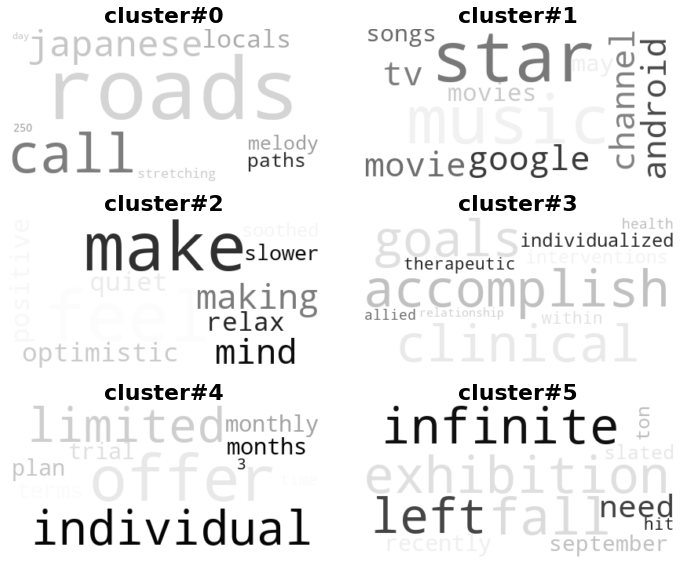

In [5]:
output = tm.perform_kmeans()

In [6]:
print(output)

{'cluster#0':             cluster#0  cluster#1  cluster#2  cluster#3  cluster#4  cluster#5
roads        108.7626     0.0000        0.0        0.0        0.0        0.0
locals        68.6216    -0.0000        0.0        0.0        0.0        0.0
melody        68.6216    -0.0000        0.0        0.0        0.0        0.0
japanese      68.6216    -0.0000        0.0        0.0        0.0        0.0
paths         68.6216    -0.0000        0.0        0.0        0.0        0.0
stretching    68.6216    -0.0000        0.0        0.0        0.0        0.0
175           68.6216    -0.0000        0.0        0.0        0.0        0.0
call          68.6216    -0.0000        0.0        0.0        0.0        0.0
250           45.7477     0.2383        0.0        0.0        0.0        0.0
day           34.3108     0.3574        0.0        0.0        0.0        0.0, 'cluster#1':          cluster#0  cluster#1  cluster#2  cluster#3  cluster#4  cluster#5
star        0.0000     0.9239     0.0000     0.0000